In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
#import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from collections import Counter

env = gym.make("CartPole-v0")
observation = env.reset()
print(observation)

[-0.0173757  -0.0470849  -0.01227378  0.03193376]


In [2]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    'lr': 0.0005,
    'dropout': 0.3,
    'epochs': 1,
    'batch_size': 256, #256,
    'pareto': 100, # a factor to multiply action loss by to get optimal loss
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
    'goal_steps': 201, #200 is the limit for cart-pole
    'score_requirement': 60,
    'initial_games': 50000,
    'policyUpdates': 3,
    'policyEpisodes': 250,
})
print(args.pareto)

100


# Execute Episode, Policy Iteration and Initial Episodes

In [3]:
def policyIteration():
    
    scores = np.array([])
    
    prev_nnet = Net()
    init_examples, prev_mean, prev_median = initialExamples(init_model = None)  # good
    prev_net, a_loss, v_loss, batch_acc = prev_nnet.train_model(examples = init_examples)
    
    for i in range(args.policyUpdates):
        
        # ----- GENERATE A BATCH OF EPISODES BASED ON THE PREVIOUS NET----------
        exampleBatch = []
        for e in range(args.policyEpisodes):
            example = executeEpisode(episode_model = prev_nnet)
            scores = np.append(scores, example[0, 5])
            
            if len(exampleBatch) == 0:
                exampleBatch = example
            else:
                exampleBatch = np.vstack(   (exampleBatch, example)   )
                
        
        # -------- CREATE CHALLENGER POLICY BASED ON EXAMPLES GENERATED BY PREVIOUS POLICY -------------------
        new_nnet = Net() # create a new net to train
        new_net, a_loss, v_loss, batch_acc = new_nnet.train_model(examples = exampleBatch)
                
            
        # -------- PRINT STATS ON NEW POLICY -------------
        mean, median = np.mean(scores), np.median(scores)
        print('Average accepted score: ', mean)
        print('Median score for accepted scores: ', median)
        print(Counter(scores))
        print("Current Policy: ", prev_mean, prev_median)
        
        # ---------- COMPARE AND UPDATE POLICIES --------------
        if mean >= prev_mean and median >= prev_median:
            prev_nnet = new_nnet
            prev_mean, prev_median = mean, median
            print("Policy Updated!")
            print("New Policy: ", prev_mean, prev_median)
    
    #x = np.linspace(1, len(a_loss), num = len(a_loss))
    #plt.plot(x, a_loss)
    #plt.plot(x, v_loss)
    #plt.plot(x, batch_acc)
    #plt.legend(["action loss", "value loss", "batch accuracy"])
    #plt.show()

    return prev_nnet

In [4]:
def executeEpisode(episode_model = None):
    ''' Generate and example episode of [4 x observation(t), action(t), E[return(t)]]. 
        All values are in a (n x 6) numpy array where n is the number of steps for the 
        episode to finish or the limit of 200 steps'''
    score = 0
    example = np.zeros((args.goal_steps, 6) )
    prev_observation = env.reset() # list of 4 elements

    # --------- ITERATE UP TO 500 STEPS PER EPISODE -------------
    for t in range(args.goal_steps):

        # --------- GENERATE ACTION ------------
        # We can generate random actions or actions from the previous policy (i.e. prev nnet)
        if episode_model == None or t == 0:
            action = env.action_space.sample()   # choose random action (0-left or 1-right)
        else:
            x = torch.tensor(   prev_observation,   dtype = torch.float    )
            action_prob, e_score = episode_model.forward(x)
            action = np.argmax(   action_prob.detach().numpy()   )                

        observation, reward, done, info = env.step(action)

        # --------- STORE STATE-ACTION PAIR + SCORE ------------
        example[t, 0:4] = prev_observation[0:4]
        example[t, 4:6] = [action, score]

        prev_observation = np.array(observation)
        score += reward    # +1 for every frame we haven't fallen
        
        if done: 
            break
    
    example[:, 5] = score - example[:, 5]    # Convert scores to E[return] 
    return example[0:int(score), :] # we only want to return the parts with actual values

In [5]:
def initialExamples(init_model = None):
    allExamples = []
    accepted_scores = np.array([])    # just the scores that met our threshold
    
    # --------------- ITERATE THROUGH 10000 EPISODE ------------------
    for _ in range(args.initial_games):
        
        exampleGame = executeEpisode(init_model)
                
        # --------- SAVE EXAMPLE (EPISODE) IF (SCORE > THRESHOLD) ----------
        # Note, it does not save the score! Therefore all episodes with score > threshold
        # are treated equally (not the best way of doing this!)
        if exampleGame[0, 5] >= args.score_requirement:
            
            accepted_scores = np.append(accepted_scores, exampleGame[0, 5])
            
            if len(allExamples) == 0:
                allExamples = exampleGame
            else:
                allExamples = np.vstack(   (allExamples, exampleGame)   )
            

    # -------- PRINT STATS ------------
    avg_mean, avg_median = np.mean(accepted_scores), np.median(accepted_scores)
    print('Average accepted score: ', avg_mean)
    print('Median score for accepted scores: ', avg_median)
    print(Counter(accepted_scores))
    print(len(accepted_scores))
    
    # allExamples = 
    # [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 1.00000000e+00  6.00000000e+01]
    #  [-3.24068081e-03  1.64771352e-01 -3.16792698e-02 -3.25574508e-01 0.00000000e+00  5.90000000e+01]
    #  [ 5.47462244e-05 -2.98855626e-02 -3.81907599e-02 -4.30477865e-02 0.00000000e+00  5.80000000e+01]
    
    return allExamples, avg_mean, avg_median

In [6]:
training_data, mean, median = initialExamples(init_model = None)

Average accepted score:  70.85677419354839
Median score for accepted scores:  67.0
Counter({60.0: 60, 62.0: 57, 64.0: 49, 61.0: 49, 65.0: 48, 63.0: 48, 66.0: 42, 69.0: 37, 67.0: 35, 71.0: 33, 76.0: 27, 70.0: 27, 68.0: 24, 73.0: 22, 72.0: 19, 74.0: 16, 75.0: 14, 79.0: 14, 78.0: 13, 81.0: 12, 77.0: 12, 80.0: 11, 84.0: 9, 91.0: 9, 82.0: 8, 85.0: 7, 86.0: 7, 88.0: 6, 96.0: 6, 90.0: 5, 87.0: 5, 83.0: 5, 93.0: 4, 103.0: 4, 98.0: 4, 102.0: 4, 95.0: 3, 92.0: 3, 101.0: 2, 97.0: 2, 107.0: 2, 99.0: 1, 89.0: 1, 123.0: 1, 110.0: 1, 126.0: 1, 120.0: 1, 105.0: 1, 130.0: 1, 112.0: 1, 111.0: 1, 108.0: 1})
775


# Create Policy (Neural Net model)

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 32)
        
        self.dp = nn.Dropout(p = args.dropout)  # Suragnair used 0.3
        self.fc1 = nn.Linear(32, 2)    # want an action vector output: [log(prob right), log(prob left)]
        self.fc2 = nn.Linear(32, 1)    # Output the expected return

    def forward(self, obs):
        #in_size = x.size(0)
        x = F.relu(self.dp(self.l1(obs)))
        x = F.relu(self.dp(self.l2(x)))
        x = F.relu(self.dp(self.l3(x)))
        x = F.relu(self.dp(self.l4(x)))
        
        #x = x.view(in_size, -1)  # flatten the tensor
        a = self.fc1(self.dp(x))
        action_probs = F.log_softmax(a, dim = -1)    # choose the dimension such that we get something like 
                                                     # [exp(-0.6723) +  exp(-0.7144)] = 1 for the output
        v = self.fc2(self.dp(x))  # get a linear value for the expected return
        return action_probs, v                      
    
    
    def train_model(self, examples):
        optimizer = optim.Adam(self.parameters(), lr=args.lr)
        action_loss, value_loss, accuracy = [], [], []

        # ------------- CONVERT TO CORRECT DATA TYPE ----------------
        gpu = torch.device("cpu")
        states = torch.tensor(  examples[:, 0:4] ,  dtype = torch.float)       #reshapes into a (23002, 4) array
        target_actions = torch.tensor(  examples[:, 4], dtype = torch.long)    #reshapes into a (23002, 2) array 
        target_returns = torch.tensor(  examples[:, 5],  dtype = torch.float) 
        

        #if args.cuda:  #if we're using the GPU:
        #    states, target_actions, target_returns = states.contiguous().cuda(), target_actions.contiguous().cuda(), target_returns.contiguous().cuda()
        #states, target_pis, target_vs = Variable(states), Variable(target_actions), Variable(target_returns)
        # We should permute data before batching really. (X is a torch Variable)
        #permutation = torch.randperm(X.size()[0])
        
        for epoch in range(args.epochs):
            print('EPOCH ::: ' + str(epoch+1))
            self.train()     # set module in training mode
            batch_idx = 0
            
            for index in range(0, len(target_returns) - args.batch_size, args.batch_size):        

                # -------- GET BATCHES -----------
                #indices = permutation[i:i+batch_size]
                batch_idx = int(index / args.batch_size) + 1 #add one so stats print properly
                batch_states = states[index : index+args.batch_size] # torch.Size([64, 4])
                batch_actions = target_actions[index : index+args.batch_size] # torch.Size([64])
                batch_returns = target_returns[index: index+args.batch_size] # torch.Size([64])

                # -------------------- FEED FORWARD ---------------------- 
                pred_actions, pred_return = self.forward(batch_states) # torch.Size([64, 2]) and torch.Size([64, 1])
                batch_NumWrong = torch.abs(torch.argmax(pred_actions, dim = 1) - batch_actions).sum()
            
                a_loss = F.nll_loss(pred_actions, batch_actions)
                
                #print(pred_actions.detach(), batch_actions.detach(), a_loss.detach())
                
                # Suragnair uses tanh for state_values, but their values are E[win] = [-1, 1] where -1 = loss
                # Here we are using the length of time that we have been "up"
                v_loss = F.binary_cross_entropy(torch.sigmoid(pred_return[:, 0]), torch.sigmoid(batch_returns))

                action_loss.append(a_loss);    value_loss.append(v_loss)
                tot_loss = a_loss*args.pareto + v_loss

                # ----------- COMPUTE GRADS AND BACKPROP ----------------
                optimizer.zero_grad()
                tot_loss.backward()
                optimizer.step()

                # --------- PRINT STATS --------------
                # Get array of predicted actions and compare with target actions to compute accuracy
                
                accuracy.append(  1 - (batch_NumWrong.detach().numpy()) / args.batch_size    ) #counts the different ones
                if batch_idx % 8 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {:.5f}'.format(
                            epoch+1, 
                            batch_idx * args.batch_size, 
                            states.size()[0],
                            100 * batch_idx * args.batch_size / states.size()[0], 
                            tot_loss,
                            accuracy[batch_idx - 1])

                     )

        return self, action_loss, value_loss, accuracy
    
    def test(self, render = False):
    
        self.eval()
        scores, expected_scores, choices = [], np.zeros(args.goal_steps), []

        # ------- PLAY SOME TEST GAMES ----------
        for each_game in range(10):
            env.reset()
            score, E_score = 0, []
            game_memory, prev_obs = [], []

            for _ in range(args.goal_steps):    # play up to (200) frames
                if render:
                    env.render()

                # ----- GENERATE AN ACTION -------
                if len(prev_obs)==0:    # start by taking a random action
                    action = env.action_space.sample()   

                else:                   # After that take the best predicted action by the neural net
                    x = torch.tensor(   prev_obs,   dtype = torch.float    )
                    action_prob, e_score = self.forward(x)
                    action = np.argmax(   action_prob.detach().numpy()   )
                    E_score.append(   np.array(e_score.detach())[0]   )  # see how the game updates it expected score as we move through

                new_observation, reward, done, info = env.step(action)
                prev_obs = new_observation

                # ----- RECORD RESULTS -------
                choices.append(action)   # just so we can work out the ratio of what we're predicting

                game_memory.append([new_observation, action])
                score += reward
                if done: break

            scores.append(score)    # Record the score of each game
            padding = np.zeros(int(args.goal_steps - score + 1), dtype = int)
            E_score = np.append([np.array(E_score)], [padding])
            expected_scores = np.vstack((expected_scores, E_score))

        print("\n\nTESTING:\n")
        print('Average Score:',sum(scores)/len(scores))
        print('choice 1 (right): {:.4f}  choice 0 (left): {:.4f}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
        print(Counter(scores))
        print("\nEND TEST:\n\n")
            
        return expected_scores

# Train Once

In [8]:
test_model1 = Net() # initialise the neural net
new_model, a_loss, v_loss, batch_acc = test_model1.train_model(training_data) #This produces the correct output

EPOCH ::: 1
Train Epoch: 1 [2048/56338 (4%)]	Loss: 69.858063 	Accuracy: 0.52734
Train Epoch: 1 [4096/56338 (7%)]	Loss: 69.690872 	Accuracy: 0.52344
Train Epoch: 1 [6144/56338 (11%)]	Loss: 68.923286 	Accuracy: 0.59375
Train Epoch: 1 [8192/56338 (15%)]	Loss: 69.486076 	Accuracy: 0.51953
Train Epoch: 1 [10240/56338 (18%)]	Loss: 68.278671 	Accuracy: 0.57812
Train Epoch: 1 [12288/56338 (22%)]	Loss: 67.730225 	Accuracy: 0.60547
Train Epoch: 1 [14336/56338 (25%)]	Loss: 69.943962 	Accuracy: 0.53516
Train Epoch: 1 [16384/56338 (29%)]	Loss: 67.679680 	Accuracy: 0.57031
Train Epoch: 1 [18432/56338 (33%)]	Loss: 69.338631 	Accuracy: 0.53906
Train Epoch: 1 [20480/56338 (36%)]	Loss: 69.547089 	Accuracy: 0.58594
Train Epoch: 1 [22528/56338 (40%)]	Loss: 67.982468 	Accuracy: 0.60547
Train Epoch: 1 [24576/56338 (44%)]	Loss: 68.096001 	Accuracy: 0.56641
Train Epoch: 1 [26624/56338 (47%)]	Loss: 68.886971 	Accuracy: 0.57422
Train Epoch: 1 [28672/56338 (51%)]	Loss: 69.393951 	Accuracy: 0.57812
Train Epoch: 1

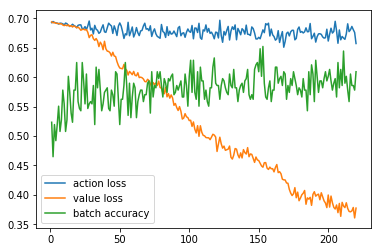

In [9]:
x = np.linspace(1, len(a_loss), num = len(a_loss))
plt.plot(x, a_loss)
plt.plot(x, v_loss)
plt.plot(x, batch_acc)
plt.legend(["action loss", "value loss", "batch accuracy"])
plt.show()

In [10]:
expected_scores = new_model.test()



TESTING:

Average Score: 198.4
choice 1 (right): 0.5060  choice 0 (left): 0.4940
Counter({200.0: 8, 194.0: 1, 190.0: 1})

END TEST:




# Iterate Policies

In [12]:
best_model = policyIteration()

Average accepted score:  71.37086092715232
Median score for accepted scores:  67.0
Counter({60.0: 54, 62.0: 53, 61.0: 50, 67.0: 48, 63.0: 47, 64.0: 44, 66.0: 43, 65.0: 40, 68.0: 36, 71.0: 29, 69.0: 25, 70.0: 24, 74.0: 21, 73.0: 21, 72.0: 20, 75.0: 18, 80.0: 17, 79.0: 14, 76.0: 13, 77.0: 12, 82.0: 11, 88.0: 9, 78.0: 9, 83.0: 8, 84.0: 7, 86.0: 6, 94.0: 5, 89.0: 5, 93.0: 5, 99.0: 4, 106.0: 4, 104.0: 4, 87.0: 4, 96.0: 4, 97.0: 4, 90.0: 4, 101.0: 3, 81.0: 3, 85.0: 3, 100.0: 2, 92.0: 2, 113.0: 2, 119.0: 2, 129.0: 2, 102.0: 2, 91.0: 2, 112.0: 1, 121.0: 1, 107.0: 1, 115.0: 1, 95.0: 1, 128.0: 1, 123.0: 1, 109.0: 1, 108.0: 1, 140.0: 1})
755
EPOCH ::: 1
Train Epoch: 1 [2048/53885 (4%)]	Loss: 70.872963 	Accuracy: 0.48438
Train Epoch: 1 [4096/53885 (8%)]	Loss: 69.304329 	Accuracy: 0.57422
Train Epoch: 1 [6144/53885 (11%)]	Loss: 70.120323 	Accuracy: 0.52344
Train Epoch: 1 [8192/53885 (15%)]	Loss: 69.949806 	Accuracy: 0.54297
Train Epoch: 1 [10240/53885 (19%)]	Loss: 70.157066 	Accuracy: 0.53516
Train

Train Epoch: 1 [30720/38913 (79%)]	Loss: 30.375399 	Accuracy: 0.87500
Train Epoch: 1 [32768/38913 (84%)]	Loss: 31.554060 	Accuracy: 0.84766
Train Epoch: 1 [34816/38913 (89%)]	Loss: 33.064869 	Accuracy: 0.86328
Train Epoch: 1 [36864/38913 (95%)]	Loss: 36.388847 	Accuracy: 0.83984
Train Epoch: 1 [38912/38913 (100%)]	Loss: 42.480579 	Accuracy: 0.77734
Average accepted score:  161.97466666666668
Median score for accepted scores:  166.0
Counter({200.0: 231, 157.0: 12, 164.0: 11, 169.0: 11, 142.0: 10, 182.0: 9, 145.0: 9, 163.0: 9, 140.0: 9, 158.0: 9, 131.0: 9, 141.0: 8, 130.0: 8, 173.0: 8, 129.0: 8, 151.0: 8, 153.0: 8, 122.0: 8, 189.0: 8, 116.0: 8, 123.0: 7, 147.0: 7, 126.0: 7, 113.0: 7, 161.0: 7, 109.0: 7, 176.0: 6, 162.0: 6, 177.0: 6, 172.0: 6, 178.0: 6, 170.0: 6, 188.0: 6, 150.0: 6, 155.0: 6, 195.0: 6, 139.0: 6, 166.0: 5, 174.0: 5, 133.0: 5, 132.0: 5, 121.0: 5, 107.0: 5, 137.0: 5, 149.0: 5, 119.0: 5, 167.0: 5, 175.0: 5, 99.0: 5, 101.0: 5, 136.0: 4, 128.0: 4, 138.0: 4, 168.0: 4, 97.0: 4, 1



TESTING:

Average Score: 173.8
choice 1 (right): 0.5046  choice 0 (left): 0.4954
Counter({200.0: 5, 139.0: 1, 176.0: 1, 165.0: 1, 111.0: 1, 147.0: 1})

END TEST:




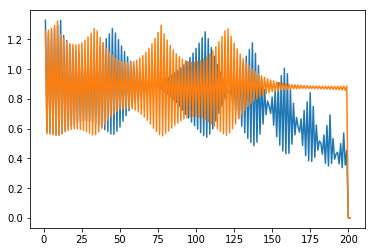

In [13]:
expected_scores = best_model.test(render = True)
x = np.linspace(1, len(expected_scores[0]), num = len(expected_scores[0]))
plt.plot(x, expected_scores[1])
#plt.plot(x, expected_scores[6])
plt.plot(x, expected_scores[3])
plt.show()